In [ ]:
!pip install --upgrade tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Instanciando la red pre-entrenada ResNet50 para aplicarla a la BD con expansión de imágenes pero esta vez con entonación fina

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras import regularizers

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix

In [2]:
conv_base  = keras.applications.resnet50.ResNet50(
    weights="imagenet",
    include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
!unzip /content/gdrive/MyDrive/TRABAJO/Trabajos_ciencia_de_datos/Clasificacion_imagenes/Dataset_bien.zip

Ajustando los datos de la BD


In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    'Dataset_bien/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
validation_dataset = image_dataset_from_directory(
    'Dataset_bien/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'Dataset_bien/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 1158 files belonging to 4 classes.
Found 252 files belonging to 4 classes.
Found 287 files belonging to 4 classes.


La fase de entrenamiento podrá alterar los pesos de las 3 últimas capas

In [4]:
conv_base.trainable = False

# conv_base.trainable = True
# for layer in conv_base.layers[:-2]:
#     layer.trainable = False

In [5]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

Transformaciones para expandir las imágenes y definición de la arquitectura


In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(768)(x)#, kernel_regularizer=regularizers.l1_l2(0.01))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [8]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

Fijar los hiperparámetros y entrenar la red

In [9]:
conv_base.trainable = False

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=1000,  #30
    batch_size=64,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/1000


37/37 [==============================] - 32s 445ms/step - loss: 26.7895 - accuracy: 0.4542 - val_loss: 54.6140 - val_accuracy: 0.3810
Epoch 2/1000
37/37 [==============================] - 16s 388ms/step - loss: 10.5108 - accuracy: 0.6451 - val_loss: 26.6548 - val_accuracy: 0.5079
Epoch 3/1000
37/37 [==============================] - 15s 354ms/step - loss: 8.4538 - accuracy: 0.7029 - val_loss: 26.7560 - val_accuracy: 0.5198
Epoch 4/1000
37/37 [==============================] - 16s 387ms/step - loss: 8.2864 - accuracy: 0.7202 - val_loss: 18.3655 - val_accuracy: 0.5595
Epoch 5/1000
37/37 [==============================] - 17s 416ms/step - loss: 6.7487 - accuracy: 0.7625 - val_loss: 14.8570 - val_accuracy: 0.5873
Epoch 6/1000
37/37 [==============================] - 15s 349ms/step - loss: 6.8049 - accuracy: 0.7720 - val_loss: 15.8101 - val_accuracy: 0.6230
Epoch 7/1000
37/37 [==============================] - 18s 431ms/step - loss: 4.7685 - accuracy: 0.7988 - val_loss: 12.5712 - val_accura

Visualizando la pérdida y el accuracy durante el entrenamiento


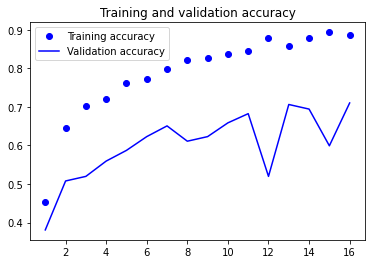

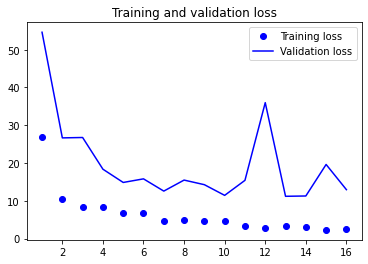

In [10]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [11]:
model.evaluate(test_dataset)

9/9 [==============================] - 3s 165ms/step - loss: 11.8402 - accuracy: 0.7247


[11.840176582336426, 0.7247386574745178]

In [ ]:
from ke2ras.models import load_model
saved_model = load_model('best_model.h5')
train_acc = saved_model.evaluate(train_dataset, verbose=0)
test_acc = saved_model.evaluate(test_dataset, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc[1], test_acc[1]))

### Matriz de confusión y métricas relevantes

In [ ]:
import numpy as np

In [ ]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_train = []  # store predicted labels
labels_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 1s 884ms/step


Hago el siguiente procedimiento porque en el código anterior los últimos
vectores que se agregan en las listas no es del mismo tamaño que los que se venían agregando,
entonces extraigo eso últimos vectores para agregar sus elementos al final.

Además, para las siguientes matrices hago lo mismo

In [ ]:
ultimo_label_train = labels_train.pop()
ultima_prediccion_train = predicciones_train.pop()

labels_train = np.array([np.argmax(i, axis = - 1) for i in labels_train]).flatten()
predicciones_train = np.array(predicciones_train).flatten()

ultimo_label_train = np.array([np.argmax(i, axis = - 1) for i in ultimo_label_train]).flatten()
labels_train = np.concatenate((labels_train, ultimo_label_train))
predicciones_train = np.concatenate((predicciones_train, ultima_prediccion_train))

[[219   1   4  44]
 [  2 248  38  21]
 [  4   4 220  27]
 [  2   1  14 309]]


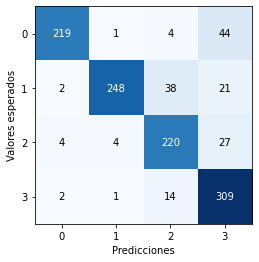

              precision    recall  f1-score   support

           0       0.96      0.82      0.88       268
           1       0.98      0.80      0.88       309
           2       0.80      0.86      0.83       255
           3       0.77      0.95      0.85       326

    accuracy                           0.86      1158
   macro avg       0.88      0.86      0.86      1158
weighted avg       0.88      0.86      0.86      1158



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_train,predicciones_train)
print(cf)
## this command is only for google collab 
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
                                
## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_train,predicciones_train))

In [ ]:
validation_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_val_train = []  # store predicted labels
labels_val_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_val_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_val_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 32ms/step


In [ ]:
ultimo_label_val_train = labels_val_train.pop()
ultima_prediccion_val_train = predicciones_val_train.pop()

labels_val_train = np.array([np.argmax(i, axis = - 1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

labels_val_train = np.concatenate((labels_val_train, np.argmax(ultimo_label_val_train, axis = - 1)))
predicciones_val_train = np.concatenate((predicciones_val_train, ultima_prediccion_val_train))

[[39  1  3 15]
 [ 2 44 12 10]
 [ 0  7 42  6]
 [ 2  0  4 65]]


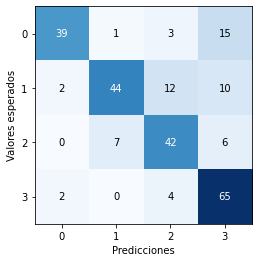

              precision    recall  f1-score   support

           0       0.91      0.67      0.77        58
           1       0.85      0.65      0.73        68
           2       0.69      0.76      0.72        55
           3       0.68      0.92      0.78        71

    accuracy                           0.75       252
   macro avg       0.78      0.75      0.75       252
weighted avg       0.78      0.75      0.75       252



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_val_train,predicciones_val_train)
print(cf)
## this command is only for google collab 
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
                                
## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_val_train,predicciones_val_train))

In [ ]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_test = []  # store predicted labels
labels_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_test.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_test.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 37ms/step


In [ ]:
ultimo_label_test = labels_test.pop()
ultima_prediccion_test = predicciones_test.pop()

labels_test = np.array([np.argmax(i, axis = - 1) for i in labels_test]).flatten()
predicciones_test = np.array(predicciones_test).flatten()

labels_test = np.concatenate((labels_test, np.argmax(ultimo_label_test, axis = - 1)))
predicciones_test = np.concatenate((predicciones_test, ultima_prediccion_test))

[[43  2  2 19]
 [ 4 45 14 14]
 [ 2  3 43 15]
 [ 2  1  3 75]]


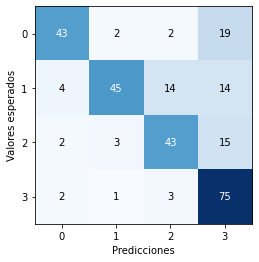

              precision    recall  f1-score   support

           0       0.84      0.65      0.74        66
           1       0.88      0.58      0.70        77
           2       0.69      0.68      0.69        63
           3       0.61      0.93      0.74        81

    accuracy                           0.72       287
   macro avg       0.76      0.71      0.72       287
weighted avg       0.75      0.72      0.72       287



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_test,predicciones_test)
print(cf)
## this command is only for google collab 
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
                                
## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_test,predicciones_test))

### Guardar el modelo con Tensorflow Lite para correr en Raspberry

In [ ]:
import tensorflow as tf
import pathlib

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
#tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir = pathlib.Path(".")
tflite_model_file = tflite_models_dir/"model_ResNet50.tflite"
tflite_model_file.write_bytes(tflite_model)

320480548

In [ ]:
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]

In [ ]:
# tflite_models_dir = pathlib.Path(".")
# tflite_fp16_model = converter.convert()
# tflite_model_fp16_file = tflite_models_dir/"model_VGG16_quant_f16.tflite"
# tflite_model_fp16_file.write_bytes(tflite_fp16_model)